In [1]:
# ANALYSIS OPTIONS
jobs_lower_limit = 50
pop_lower_limit = 1000

print('Importing packages...')
import os
import pandas
import numpy as np
import time
from matplotlib import pyplot as plt
from IPython.display import display, HTML
import matplotlib.patches as mpatches
import geopandas
from shapely.geometry import Point
import scipy
from scipy import stats as stats
#from mpl_toolkits.axes_grid1 import make_axes_locatable

pandas.set_option('display.max_colwidth', -1)
debug = 1
summary = {}

# Directories to look in
thisdir = '/home/idies/workspace/Storage/raddick/Baltimore/community_reinvestment_act/'
data_dir = '/home/idies/workspace/Temporary/raddick/cra_scratch_final/'
census_dir = data_dir + 'acs5/'
baltimore_dir = thisdir + 'baltimore/'
city_data_dir = thisdir + 'city_data/'
code_lookup_dir = thisdir + 'code_guide_lookups/'
inflation_dir = '/home/idies/workspace/Storage/raddick/Baltimore/community_reinvestment_act/datasets/inflation/'
figdir = thisdir + 'figures/'
mapdir = thisdir + 'maps/'
shapefile_basedir = '/home/idies/workspace/Storage/raddick/Baltimore/shapefiles/'
census_shapefile_tiger_basedir = '/home/idies/workspace/Temporary/raddick/census_scratch/shapefiles/'



# MAPPING OPTIONS
scale = 0.125
thecolormap = 'viridis'
show_tract_labels = False
show_plot_labels = True

g = 0  # keep track of grand total of processing time
os.chdir(thisdir)
print('Now in directory: {0:}'.format(os.getcwd()))
print('ok')

Importing packages...
Now in directory: /home/idies/workspace/Storage/raddick/Baltimore/community_reinvestment_act
ok


# DONE!!!!!!!!!!!!!!!!! NOW WE CAN ANALYZE!!!!!!!!!!!!!!!!!!!!

## Get data

In [2]:
df = pandas.read_csv(city_data_dir+'baltimore_alldata.csv', encoding='utf-8', index_col=['census_tract','activity_year'])
print('Done')

Done


In [3]:
print('Summing loans across all years for each tract...')
tract_columns = ['nLoans1','nLoans100k','nLoans250k','nLoansToSmallest']
tract_columns += ['nLoans','nWorkingLoans']
tract_columns += ['nLoans1_per_totaljob','nLoans100k_per_totaljob']
tract_columns += ['nLoans250k_per_totaljob','nLoansToSmallest_per_totaljob']
tract_columns += ['nLoans_per_totaljob','nWorkingLoans_per_totaljob']
tract_columns += ['nLoans1_per_sbjob','nLoans100k_per_sbjob','nLoans250k_per_sbjob']
tract_columns += ['nLoansToSmallest_per_sbjob','nLoans_per_sbjob','nWorkingLoans_per_sbjob']
tract_columns += ['amtLoans1_adj','amtLoans100k_adj', 'amtLoans250k_adj']
tract_columns += ['amtLoansToSmallest_adj','amtLoans_adj', 'amtWorkingLoans_adj']
tract_columns += ['amtLoans1_per_totaljob_adj','amtLoans100k_per_totaljob_adj']
tract_columns += ['amtLoans250k_per_totaljob_adj','amtLoansToSmallest_per_totaljob_adj']
tract_columns += ['amtLoans_per_totaljob_adj','amtWorkingLoans_per_totaljob_adj']
tract_columns += ['amtLoans1_per_sbjob_adj','amtLoans100k_per_sbjob_adj']
tract_columns += ['amtLoans250k_per_sbjob_adj','amtLoansToSmallest_per_sbjob_adj']
tract_columns += ['amtLoans_per_sbjob_adj','amtWorkingLoans_per_sbjob_adj']

tracts_df = df.reset_index().groupby('census_tract')[tract_columns].sum()

print('Keeping only tracts that were the same across all years...')
nYears_s = df.reset_index().groupby('census_tract').size()
nYears_s.name = 'nYears'
tracts_df = tracts_df.join(nYears_s)

nTractsTotal = len(tracts_df)
##tracts_df.groupby('nYears').size()
nTracts7years = len(tracts_df[tracts_df['nYears'] == 7])

print('Keeping only tracts with loans every year: {0:,.0f} out of {1:,.0f} total tracts...'.format(nTracts7years, nTractsTotal))
tracts_df = tracts_df[tracts_df['nYears'] == 7]

print('ok')


Summing loans across all years for each tract...
Keeping only tracts that were the same across all years...
Keeping only tracts with loans every year: 187 out of 207 total tracts...
ok


In [4]:
print('joining CRA levels...')
tract_info_2017_df = df.reset_index().set_index('census_tract')[df.reset_index().set_index('census_tract')['activity_year'] == 2017][['CSA2010', 'income_group_code', 'income_group', 'cra_level']]
tract_info_2017_df = tract_info_2017_df.rename(columns={'income_group_code': 'income_group_code_2017', 'income_group': 'income_group_2017', 'cra_level': 'cra_level_2017'})
tracts_df = tracts_df.join(tract_info_2017_df, how='left')

print('Done')

joining CRA levels...
Done


In [5]:
print('reading job data...')
s = time.time()
raw_jobs_df = pandas.read_csv(baltimore_dir+'wac_jobs_df.csv', index_col='rownumber')
e = time.time()
raw_jobs_2015_df = raw_jobs_df[raw_jobs_df['year'] == 2015]
print('Read {0:,.0f} rows in {1:,.0f} seconds!'.format(len(raw_jobs_df), e-s))

print('finding census tracts...')
raw_jobs_2015_df = raw_jobs_2015_df.assign(census_tract = pandas.to_numeric(raw_jobs_2015_df['w_geocode'].apply(lambda x: str(x)[5:9] + '.' + str(x)[9:11]), errors='coerce'))#.drop_duplicates().sort_values()[0:3]
sum_columns = ['census_tract']
sum_columns += [x for x in raw_jobs_df.columns.tolist() if x not in ('w_geocode', 'createdate', 'year')]

print('grouping by census tract...')
jobs_2015_df = raw_jobs_2015_df[sum_columns].groupby('census_tract').sum()

print('joining jobs...')
tracts_df = tracts_df.join(jobs_2015_df[['C000', 'CFS01']], how='left')
tracts_df = tracts_df.rename(columns={'C000': 'total_jobs', 'CFS01': 'sb_jobs'})
print('Done!')


reading job data...


/home/idies/miniconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Read 1,691,314 rows in 13 seconds!
finding census tracts...
grouping by census tract...
joining jobs...
Done!


In [6]:
census_columns = ['pop_total', 'total_householders', 'pop_white', 'pop_black']
census_columns += ['black_householder', 'white_householder', 'female_householder', 'owner_occ_housing_units']
census_columns += ['mfi_adj', 'unemployed_16plus', 'poverty_past_12_months']
census_columns += ['median_home_value', 'median_year_built', 'labor_force_16plus']
census_columns += ['poverty_status_known', 'hs_grad_25plus', 'pop_25plus']

census_error_columns = ['pop_total_err', 'total_householders_serr', 'pop_white_err', 'pop_black_err']
census_error_columns += ['black_householder_err', 'white_householder_err', 'owner_occ_housing_units_err']
census_error_columns += ['mfi_err', 'female_householder_err', 'unemployed_16plus_err']
census_error_columns += ['poverty_past_12_months_err', 'median_home_value_err', 'median_year_built_err']
census_error_columns += ['labor_force_16plus_err', 'poverty_status_known_err']
census_error_columns += ['hs_grad_25plus_serr', 'pop_25plus_serr']

print('joining ACS 5-year estimates and margins of error...')
tracts_acs5_2017 = df.reset_index()[df.reset_index()['activity_year'] == 2017].set_index('census_tract')[census_columns]
tracts_acs5_err_2017 = df.reset_index()[df.reset_index()['activity_year'] == 2017].set_index('census_tract')[census_error_columns]

tracts_df = tracts_df.join(tracts_acs5_2017, how='left')
tracts_df = tracts_df.join(tracts_acs5_err_2017, how='left')

summary['pop_total'] = tracts_df['pop_total'].sum()
#tracts_df.head(1).T
print('Done!')


joining ACS 5-year estimates and margins of error...
Done!


In [7]:
#Guide on how to do this:
#### https://www.census.gov/content/dam/Census/library/publications/2018/acs/acs_general_handbook_2018_ch08.pdf

# X and Y are the measured values (not the errors) - X for the subsgroup and Y for the whole sample
# Let P = X/Y  (the proportion we calculated in the last step)
# dX and dY are the measured errors
# dP = (1/Y) * np.sqrt(dX**2 - (P**2 * dY**2))
# Standard error of P is dP/1.645
#### this calculation is done verbosely in fnid_pop_white_serr, quickly in other functions

def find_errors_in_pct(X, Y, dX, dY, verboselevel = 0):
    try:
        P = X / Y
        oneoverY = 1 / Y
        dXsq = dX**2
        dYsq = dY**2
        Psq = P**2
        PsqdYsq = Psq * dYsq
        if (PsqdYsq <= dXsq):
            underroot = dXsq - PsqdYsq
        else:
            underroot = dXsq + PsqdYsq
        rooty = np.sqrt(underroot)
        dP = oneoverY * rooty
        SE = dP / 1.645
        if (verboselevel >= 2):
#            print('X = pop_white, Y = pop_total')
            print('X = {0:.0f}, dX = {1:.0f} ({2:.1%} error)'.format(X, dX, dX/X))
            print('Y = {0:.0f}, dY = {1:.0f} ({2:.1%} error)'.format(Y, dY, dY/Y))
        if (verboselevel >= 3):
            print('P = {0:.3f}'.format(P))
            print('dXsq = {0:.0f}, dYsq = {1:.0f}, Psq = {2:.3f}'.format(dXsq, dYsq, Psq))
            print('PsqdYsq = {0:.0f}, underroot = {1:.0f}, rooty = {2:.3f}'.format(PsqdYsq, underroot, rooty))
            print('dP = {0:.3f}'.format(dP))
            print('SE = {0:.3f}'.format(SE))
        if (verboselevel >= 2):
            print('RESULT: {0:.2%} +/- {1:.2%}'.format(P, SE)) 
            print('\n')
        return pandas.to_numeric(SE, errors='coerce')
    except ZeroDivisionError:
        return np.nan
print('Defined functions to calculate standard errors in percentages!')
print('ok')

Defined functions to calculate standard errors in percentages!
ok


In [8]:
s = time.time()
verboselevel = 0

print('Calculating percentage values...')
tracts_df = tracts_df.assign(pct_white = tracts_df['pop_white'] / tracts_df['pop_total'])
tracts_df = tracts_df.assign(pct_black = tracts_df['pop_black'] / tracts_df['pop_total'])
tracts_df = tracts_df.assign(pct_white_householders = tracts_df['white_householder'] / tracts_df['total_householders'])
tracts_df = tracts_df.assign(pct_black_householders = tracts_df['black_householder'] / tracts_df['total_householders'])
tracts_df = tracts_df.assign(pct_female_householders = tracts_df['female_householder'] / tracts_df['total_householders'])
tracts_df = tracts_df.assign(pct_hs_grad = tracts_df['hs_grad_25plus'] / tracts_df['pop_25plus'])
tracts_df = tracts_df.assign(pct_unemployed = tracts_df['unemployed_16plus'] / tracts_df['labor_force_16plus'])
tracts_df = tracts_df.assign(pct_poverty = tracts_df['poverty_past_12_months'] / tracts_df['poverty_status_known'])

print('Calculating errors in percentages...')
tracts_df = tracts_df.assign(pct_white_serr = np.nan)
tracts_df = tracts_df.assign(pct_black_serr = np.nan)
tracts_df = tracts_df.assign(pct_white_householders_serr = np.nan)
tracts_df = tracts_df.assign(pct_black_householders_serr = np.nan)
tracts_df = tracts_df.assign(pct_female_householders_serr = np.nan)
tracts_df = tracts_df.assign(pct_hs_grad_serr = np.nan)
tracts_df = tracts_df.assign(pct_unemployed_serr = np.nan)
tracts_df = tracts_df.assign(pct_poverty_serr = np.nan)



for ix, thisrow in tracts_df.iterrows():
    if (verboselevel >= 2):
        print('Census tract {0:}...'.format(ix))
    tracts_df.loc[ix, 'pct_white_serr'] = find_errors_in_pct(thisrow['pop_white'], thisrow['pop_total'], thisrow['pop_white_err'], thisrow['pop_total_err'], verboselevel)
    tracts_df.loc[ix, 'pct_black_serr'] = find_errors_in_pct(thisrow['pop_black'], thisrow['pop_total'], thisrow['pop_black_err'], thisrow['pop_total_err'], verboselevel)
    tracts_df.loc[ix, 'pct_white_householders_serr'] = find_errors_in_pct(thisrow['white_householder'], thisrow['total_householders'], thisrow['white_householder_err'], thisrow['total_householders_serr'], verboselevel)
    tracts_df.loc[ix, 'pct_black_householders_serr'] = find_errors_in_pct(thisrow['black_householder'], thisrow['total_householders'], thisrow['black_householder_err'], thisrow['total_householders_serr'], verboselevel)
    tracts_df.loc[ix, 'pct_female_householders_serr'] = find_errors_in_pct(thisrow['female_householder'], thisrow['total_householders'], thisrow['black_householder_err'], thisrow['total_householders_serr'], verboselevel)
    tracts_df.loc[ix, 'pct_hs_grad_serr'] = find_errors_in_pct(thisrow['hs_grad_25plus'], thisrow['pop_25plus'], thisrow['hs_grad_25plus_serr'], thisrow['pop_25plus_serr'], verboselevel)
    tracts_df.loc[ix, 'pct_unemployed_serr'] = find_errors_in_pct(thisrow['unemployed_16plus'], thisrow['labor_force_16plus'], thisrow['hs_grad_25plus_serr'], thisrow['labor_force_16plus_err'], verboselevel)
    tracts_df.loc[ix, 'pct_poverty_serr'] = find_errors_in_pct(thisrow['poverty_past_12_months'], thisrow['poverty_status_known'], thisrow['poverty_past_12_months_err'], thisrow['poverty_status_known_err'], verboselevel)

if (verboselevel >= 1):
    for ix, thisrow in tracts_df.iterrows():
        print('Census tract {0:,.0f}'.format(ix))
        print('{0:,.0f} +/- {1:,.0f} white'.format(
            thisrow['pop_white'], thisrow['pop_white_err']
        ))
        print('{0:,.0f} +/- {1:,.0f} total'.format(
            thisrow['pop_total'], thisrow['pop_total_err']
        ))
        print('{0:.1%} +/- {1:.1%}'.format(
            thisrow['pct_white'], thisrow['pct_white_serr']
        ))
        print('\n')

print('backing up...')
tracts_df_bk = tracts_df

e = time.time()
print('Processed {0:,.0f} rows in {1:,.2f} seconds!'.format(len(tracts_df), e-s))


Calculating percentage values...
Calculating errors in percentages...
backing up...
Processed 187 rows in 2.47 seconds!


In [9]:
thisyear = 2017

if (debug > 0):
    print('Getting census tract shapefiles for {0:.0f}...'.format(thisyear))
tract_shapes_gdf = geopandas.read_file(census_shapefile_tiger_basedir +'{0:.0f}/TRACT/tl_{0:.0f}_24_tract.shp'.format(thisyear))
tract_shapes_gdf = tract_shapes_gdf[tract_shapes_gdf['COUNTYFP'] == '510']
tract_shapes_gdf.loc[:, 'NAME'] = pandas.to_numeric(tract_shapes_gdf['NAME'], errors='coerce')
tract_shapes_gdf = tract_shapes_gdf.assign(census_tract = pandas.to_numeric(tract_shapes_gdf['GEOID'].apply(lambda x: x[5:9]+'.'+x[9:]), errors='coerce'))
tract_shapes_gdf = tract_shapes_gdf.drop('GEOID', axis=1)
tract_shapes_gdf = tract_shapes_gdf.set_index('census_tract')

print('cutting out harbor...')
water_gdf = geopandas.read_file(shapefile_basedir+'water/water.shp')
water_gdf = water_gdf.to_crs(tract_shapes_gdf.crs)

tract_shapes_gdf = geopandas.overlay(tract_shapes_gdf, water_gdf[water_gdf['NAME'] == 'Harbor'], how='difference')

print('joining shapefiles onto data...')
#tracts_df = tracts_df.join(tract_shapes_gdf, how='left')#, lsuffix='_loans', rsuffix='_shapes')#[['GEOID_loans', 'GEOID_shapes']]
tracts_gdf = geopandas.GeoDataFrame(tracts_df.join(tract_shapes_gdf, how='left'), crs=tract_shapes_gdf.crs)

print('backing up geodataframe...')
tracts_gdf_bk = tracts_gdf

print("Done!")
#tracts_df.head(1).T


Getting census tract shapefiles for 2017...
cutting out harbor...
joining shapefiles onto data...
backing up geodataframe...
Done!


In [10]:
print('getting from backup...')
tracts_df = tracts_df_bk

tracts_included_df = tracts_df[
    (tracts_df['sb_jobs'] >= jobs_lower_limit)
    & (tracts_df['pop_total'] >= pop_lower_limit)
    & (tracts_df['cra_level_2017'] != 'unknown')
]
tracts_included_gdf = tracts_gdf[
    (tracts_gdf['sb_jobs'] >= jobs_lower_limit)
    & (tracts_gdf['pop_total'] >= pop_lower_limit)
    & (tracts_df['cra_level_2017'] != 'unknown')
]

print('identifying tracts with much or little poverty...')

tracts_included_df = tracts_included_df.assign(poverty_rate = tracts_df['poverty_past_12_months'] / tracts_df['poverty_status_known'])

#print('Quantiles of poverty rate in Baltimore city:')
#print('Median {0:.1%}, richest decile {1:.1%}, richest quartile {2:.1%}, poorest quartile {3:.1%}, poorest decile {4:.1%}'.format(
#    tracts_df['poverty_rate'].quantile(0.5), 
#    tracts_df['poverty_rate'].quantile(0.1), 
#    tracts_df['poverty_rate'].quantile(0.25), 
#    tracts_df['poverty_rate'].quantile(0.75), 
#    tracts_df['poverty_rate'].quantile(0.9)
#))

#print('\n')
#htmlstring = ''
#htmlstring += "<p>OK, sure, let's use Chicago's definition of high poverty as >= 10% poverty rate</p>"

tracts_included_df = tracts_included_df.assign(poverty_class = np.nan)
tracts_included_df.loc[tracts_included_df['poverty_rate'] > 0.3, 'poverty_class'] = 'much'
tracts_included_df.loc[tracts_included_df['poverty_rate'] < 0.1, 'poverty_class'] = 'little'

print('calculating excess white and excess black tracts...')
city_pct_white = tracts_included_df['pop_white'].sum() / tracts_included_df['pop_total'].sum()
city_pct_black = tracts_included_df['pop_black'].sum() / tracts_included_df['pop_total'].sum()
print('City-wide percent of white residents: {0:.0%}'.format(city_pct_white))
print('City-wide percent of black residents: {0:.0%}'.format(city_pct_black))

tracts_df = tracts_df.assign(excess_race = 'none')

tracts_included_df.loc[tracts_df['pct_white'] > city_pct_white, 'excess_race'] = 'white'
tracts_included_df.loc[tracts_df['pct_black'] > city_pct_black, 'excess_race'] = 'black'

summary['nTracts'] = len(tracts_included_df)
summary['pop_total'] = tracts_included_df['pop_total'].sum()
summary['nSBjobs'] = tracts_included_df['sb_jobs'].sum()


summary['nWorkingLoans'] = tracts_included_df['nWorkingLoans'].sum()
summary['amtWorkingLoans_adj'] = tracts_included_df['amtWorkingLoans_adj'].sum()

summary['city_pct_black'] = city_pct_black

print('Done!')

getting from backup...
identifying tracts with much or little poverty...
calculating excess white and excess black tracts...
City-wide percent of white residents: 37%
City-wide percent of black residents: 55%
Done!


BALTIMORE
making basic plot...
setting options...
adding colorbar...


Excess Race,Number of tracts,Mean loan amountper small business job,Standard errorof the mean
White,55,"$61,011","$4,531"
Black,66,"$36,083","$3,673"
White / Black,-,1.69,-


Number of tracts included in analysis: 124
Population included: 415,228
Percent black residents: 55.4%


Number of working loans: 33,404
Total amount of working loans: $1,669,639,675
Number of small business jobs: 30,184


Ratio of lending to white vs. black tracts: 1.69
Linear fit of lending to percent black slope: $-338
Linear fit of lending to percent black r^2 value: 0.114


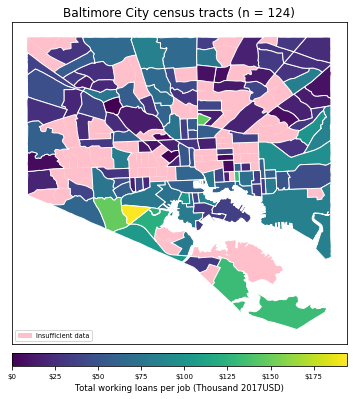

In [11]:
print('BALTIMORE')

htmlstring = ''
htmlstring += '<p><strong>JOBS lower limit: {0:,.0f}</strong></p>'.format(jobs_lower_limit)
htmlstring += '<p><strong>POPULATION lower limit: {0:,.0f}</strong></p>'.format(pop_lower_limit)

print('making basic plot...')
map1, ax = plt.subplots(1,1, figsize=(48*scale, 48*scale))

tract_shapes_gdf.plot(ax=ax, color='pink')

vmax = tracts_included_gdf['amtWorkingLoans_per_sbjob_adj'].max()

tracts_included_gdf.plot(column='amtWorkingLoans_per_sbjob_adj', ax=ax, cmap=thecolormap, edgecolor='white')

print('setting options...')
ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
plt.title('Baltimore City census tracts (n = {0:,.0f})'.format(
    len(tracts_included_gdf), fontsize=80*scale))

pink_patch = mpatches.Patch(color='pink', label='Insufficient data')
plt.legend(handles=[pink_patch], loc='lower left', fontsize=52*scale)

print('adding colorbar...')

cax = map1.add_axes([0.125, 0.08, 0.775, 0.03])

sm = plt.cm.ScalarMappable(cmap=thecolormap, norm=plt.Normalize(
    vmin=0, 
    vmax=vmax
))
## fake up the array of the scalar mappable. Urgh...
sm._A = []

cbar = map1.colorbar(sm, cax=cax, format='$%.0f', 
                    ticks=np.arange(0, 
                                    vmax, 
                                    25000), 
                    orientation='horizontal')

cax.set_xticklabels(['${:,.0f}'.format(x/1000) for x in np.arange(0, vmax, 25000)], fontsize=56*scale)
cbar.set_label('Total working loans per job (Thousand 2017USD)', fontsize=68*scale)

if (show_tract_labels):
    print('adding tract labels...')
    for ix, thisrow in tracts_gdf.iterrows():
        annotator = str(ix).replace('-', '- ')
        annotator = annotator.replace('/', '/ ')
        annotator = annotator.replace(' ', '\n')
        annotator = annotator.upper()
        annotator += '\n'
        annotator += '${0:,.0f}k'.format(thisrow['amtWorkingLoans_per_sbjob_adj']/1000)
        ax.annotate(annotator, 
                    xy=(thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
                    xytext=(thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
                    backgroundcolor = 'white',
                    horizontalalignment='center',
                    verticalalignment='center',
                    fontsize=24*scale)
        map_outfile_name = 'balt_overall_map_labeled.jpg'
else:
    map_outfile_name = 'balt_overall_map_unlabeled.jpg'

htmlstring += '<table>'
htmlstring += '<tr><th>Excess Race</th><th>Number of tracts</th><th>Mean loan amount<br />per small business job</th><th>Standard error<br />of the mean</th></tr>'
htmlstring += '<tr><td>{0:}</td><td>{1:.0f}</td><td>${2:,.0f}</td><td>${3:,.0f}</td></tr>'.format(
    'White', 
    len(tracts_included_df['amtWorkingLoans_per_sbjob_adj'][tracts_included_df['excess_race'] == 'white']), 
    tracts_included_df['amtWorkingLoans_per_sbjob_adj'][tracts_included_df['excess_race'] == 'white'].mean(),
    tracts_included_df['amtWorkingLoans_per_sbjob_adj'][tracts_included_df['excess_race'] == 'white'].sem()
)
htmlstring += '<tr><td>{0:}</td><td>{1:.0f}</td><td>${2:,.0f}</td><td>${3:,.0f}</td></tr>'.format(
    'Black', 
    len(tracts_included_df['amtWorkingLoans_per_sbjob_adj'][tracts_included_df['excess_race'] == 'black']), 
    tracts_included_df['amtWorkingLoans_per_sbjob_adj'][tracts_included_df['excess_race'] == 'black'].mean(),
    tracts_included_df['amtWorkingLoans_per_sbjob_adj'][tracts_included_df['excess_race'] == 'black'].sem()
)
htmlstring += '<tr><td>{0:}</td><td>-</td><td>{1:.2f}</td><td>-</td>'.format('White / Black', 
                                                    tracts_included_df['amtWorkingLoans_per_sbjob_adj'][tracts_included_df['excess_race'] == 'white'].mean() /
                                                    tracts_included_df['amtWorkingLoans_per_sbjob_adj'][tracts_included_df['excess_race'] == 'black'].mean()
                                                   )
htmlstring += '</table>'
display(HTML(htmlstring))

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(
    tracts_included_df['pct_black'].apply(lambda x: x * 100).values, 
    tracts_included_df['amtWorkingLoans_per_sbjob_adj'].values
)

summary['lending_ratio_race'] = tracts_included_df['amtWorkingLoans_per_sbjob_adj'][tracts_included_df['excess_race'] == 'white'].mean() / tracts_included_df['amtWorkingLoans_per_sbjob_adj'][tracts_included_df['excess_race'] == 'black'].mean()
summary['lending_race_linear_fit'] = slope
summary['lending_race_linear_rsq'] = r_value ** 2

print('Number of tracts included in analysis: {0:.0f}'.format(summary['nTracts']))
print('Population included: {0:,.0f}'.format(summary['pop_total']))
print('Percent black residents: {0:.1%}'.format(summary['city_pct_black']))
print('\n')
print('Number of working loans: {0:,.0f}'.format(summary['nWorkingLoans']))
print('Total amount of working loans: ${0:,.0f}'.format(summary['amtWorkingLoans_adj']))
print('Number of small business jobs: {0:,.0f}'.format(summary['nSBjobs']))
print('\n')
print('Ratio of lending to white vs. black tracts: {0:,.2f}'.format(summary['lending_ratio_race']))
print('Linear fit of lending to percent black slope: ${0:,.0f}'.format(summary['lending_race_linear_fit']))
print('Linear fit of lending to percent black r^2 value: {0:,.3f}'.format(summary['lending_race_linear_rsq']))

plt.show()